# EEMD + LSTM

## Data Description

    - Raw data: Historical Product Demand.csv

    - Input data: Data on 8x augmentation of demand records by selecting 8 representative items

    - Product code: 'Product_0025', 'Product_0739', 'Product_0901', 'Product_1154',
                    'Product_1248', 'Product_1295', 'Product_1378', 'Product_2004'
            

    - Size of Data: 116392 rows × 4 columns

    - Features: Date, Product_Code, Product_Category, Order_Demand

    - Period: 2012-01-01 ~ 2017-01-09


---

In [21]:
# DataFrame
import pandas as pd
import numpy as np
import random
from datetime import datetime, date

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

#Save the log
import os
import time
import pickle
import tempfile

# EEMD
from PyEMD import EEMD

# LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Optimize
from keras_tuner.tuners import RandomSearch

# Metric 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

## Data Explore

In [22]:
# # Data Loading
# df = pd.read_csv('Data\HPD_0416.csv')
# # convert the string to the datetype
# df['Date'] = pd.to_datetime(df['Date'])
# start_date = pd.to_datetime('2012-01-10')
# end_date = pd.to_datetime('2016-12-21')

# df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
# df.reset_index(drop=True)

### 다른 데이터 적용

In [23]:
df = pd.read_csv('Data\\train.csv')
df = df[(df['store']==1)]

pd.to_datetime(df['date'].max()) - pd.to_datetime(df['date'].min())
df = df.reset_index(drop=True)
df.rename(columns={'date': 'Date', 'item':'Product_Code', 'sales':'Order_Demand'}, inplace=True)
df = df[['Date', 'Product_Code', 'Order_Demand']]
df['Date'] = pd.to_datetime(df['Date'])
df['Product_Code'] = df['Product_Code'].astype('str')

In [124]:
# print(df.info())
# print('-------------------------')
# print("")
# print("The Number of unique")
# print('-------------------------')
# print('Product code:\t', df.Product_Code.nunique())
# #print('Category:\t', df.Product_Category.nunique())
# print('-------------------------')
# print("The Product Code:")
# print("")
# # for i, code in enumerate(df['Product_Code'].unique()):
# #     print(i+1, code)

---

## EEMD
    * 시계열 그래프를 ensembled IMF (앙상블 내재모드 함수)로 분해
    * n 개의 eIMFs와  1개의 Residual 생성

In [128]:
def eemd_fit(df, trials):
    # Define signal
    t = np.array(df['Date']) # x-axis
    s = np.array(df['Order_Demand']) # y-axis
    
    # EEMD 객체 생성
    eemd = EEMD() # trials: EMD 횟수(default:100)
    
#     # 극값을 감지하는 방법으로 parabolic 방법을 선택
#     emd = eemd.EMD
#     emd.extrema_detection="parabol"
    
    # eIMFs로 분해
    eIMFs = eemd.eemd(s, t) # max_imf: IMF 제한 개수(-1: 없음)
    nIMFs = eIMFs.shape[0] # eIMF의 개수
    
    # 분해된 eIMFs와 잔차를 변수에 할당
    imfs, residue = eemd.get_imfs_and_residue()
    
    # 앙상블 IMFs 들의 DataFrame 생성
    all_eIMFs_df = pd.DataFrame(eIMFs).transpose() 
    all_eIMFs_df[nIMFs] = residue # residue 열 마지막 열로 추가
    all_eIMFs_df.insert(0, 'Date', df['Date']) # Date 열 추가
    
    # IMF & Residue 시각화
    plt.figure(figsize=(12, nIMFs*2)) # Figure size 설정
    for i in range(nIMFs):
        plt.subplot(nIMFs+1, 1, i+1) # i번째 subplot
        plt.plot(df['Date'], all_eIMFs_df[i], 'g')
        plt.title('IMF '+str(i+1), fontsize=10)

    # Residue plot
    plt.subplot(nIMFs+1, 1, nIMFs+1)
    plt.plot(df['Date'], all_eIMFs_df[nIMFs], 'r')
    plt.title('Residue', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    return all_eIMFs_df, nIMFs # eIMF+Residue들로 이루어진 df, eIMF의 개수

### eIMFs 데이터프레임 추출

In [130]:
# eIMF들을 추출하여, Date와 y로 이루어진 데이터프레임 추출하고 딕셔너리에 저장
def extract_eIMFs(all_eIMFs_df, nIMFs):
    all_eIMFs_dict = {}
    # IMF개수+Residue(1) 만큼 반복
    for i in range(nIMFs+1):
        tmp_df = all_eIMFs_df[['Date', i]] # n번째 eIMF에 해당하는 날짜와 값 추출
        tmp_df.columns=['Date', 'y'] # i -> y 로 열이름 변경
        all_eIMFs_dict[f'eIMFs_{i}'] = tmp_df # n번째 eIMF 정보(마지막은 Residue) 딕셔너리에 저장
                            # df.columns = ['Date', 'y']
    return all_eIMFs_dict # {eIMFs_1: df1, eIMFs_2: df2, ...}

### Split the train and test set
- Input
     data: dataframe with dates and Demand data
     
- output
    - train:  whole data - valid, test
    - valid:  2 * time steps
    - test :  2 * time steps

In [131]:
def split_data(eIMF_df, time_steps, pred_days): 
    pred_days -= 1
    total_len = len(eIMF_df)
    train_end = int(total_len * 0.8) # 80% of the data for training
    val_end = int(total_len * 0.9) # next 10% for validation, remaining 10% for test
    y = eIMF_df.filter(['y']).values # y(수요량) 값
    
    # Minmax로 0~1 사이에 값이 오도록 정규화
    sc = MinMaxScaler() # 객체 생성
    y_scaled = sc.fit_transform(y) # 전체 y값 정규화
    
    # Train Data
    y_train_scaled = y_scaled[:train_end,:]

    X_train = [] 
    y_train = []
    for i in range(time_steps, train_end - pred_days): # pred_days days shifted
        X_train.append(y_train_scaled[i-time_steps:i,0]) # time steps 만큼 sliding window
        y_train.append(y_train_scaled[i+pred_days,0]) # pred_days days shifted

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # Reshape X_train for LSTM -> (batch_size, time_steps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

    # Validation Data
    y_val_scaled = y_scaled[train_end : val_end, :]

    X_val = []
    y_val = []
    for i in range(time_steps, len(y_val_scaled) - pred_days): # pred_days days shifted
        X_val.append(y_val_scaled[i-time_steps : i, 0])
        y_val.append(y_val_scaled[i+pred_days, 0]) # pred_days days shifted

    X_val = np.array(X_val)
    y_val = np.array(y_val)

    # Reshape X_val for LSTM -> (batch_size, time_steps, features)
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    
    # Test Data
    y_test_scaled = y_scaled[val_end:,:]
    
    X_test = []
    y_test = eIMF_df.iloc[val_end+time_steps+pred_days:] # pred_days days shifted
    y_test['y_norm'] = y_test_scaled[time_steps:-pred_days].reshape(-1).copy() # pred_days days shifted
    # test data 개수만큼 반복
    for i in range(time_steps, len(y_test_scaled) - pred_days): # pred_days days shifted
        X_test.append(y_test_scaled[i-time_steps : i, 0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

    
    return X_train, y_train, X_val, y_val, X_test, y_test, sc

## Optimized LSTM

In [132]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=480, step=64),
                   activation=hp.Choice('activation_1', ['relu', 'tanh']),
                   return_sequences=True, 
                   input_shape=(None,1)))
    
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32),
                   activation=hp.Choice('activation_3', ['relu', 'tanh']),
                   return_sequences=False))

    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(Dense(units=hp.Int('dense_units_' + str(i), min_value=16, max_value=64, step=16),
                        activation=hp.Choice('dense_activation_'+ str(i), ['relu', 'tanh'])))
        
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mape','mae'])

    return model

# 모델 학습 및 평가 함수
def optimize_model(X_train, y_train, X_val, y_val, X_test, sc, epochs, trials):
    with tempfile.TemporaryDirectory() as temp_dir:
        tuner = RandomSearch(
            build_model,
            objective='val_loss',
            max_trials= trials,
            directory=temp_dir,
            project_name='temp_project')

    tuner.search_space_summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    tuner.search(X_train, y_train,
                 epochs=epochs,
                 batch_size=32,
                 validation_data=(X_val, y_val),
                 callbacks=[early_stopping])

    tuner.results_summary()

    best_model = tuner.get_best_models(num_models=1)[0]

    # Test 데이터 예측
    pred = best_model.predict(X_test) # 예측값 얻기
    pred_norm = pred # 예측값을 저장하되, normalize된 값 저장
    pred = sc.inverse_transform(pred.reshape(pred.shape[0], pred.shape[1])) # denormalize된 예측값 저장
    
    best_model.summary()
    # 모델 객체와 예측값 반환
    return best_model, pred, pred_norm

### EEMD+LSTM

In [133]:
'''
EEMD의 결과로 분해된 ensembled IMF들에 대해
각각 LSTM으로 예측하여 예측값을 얻은 후,
마지막에 합산하여 전체 결과를 파악함
'''
def EEMD_LSTM(all_eIMFs_dict, time_steps, epochs, trials, pred_days):

    model_dict = {}
    pred_dict = {}
    
    # 모든 eIMF에 대해 LSTM 모델 학습 및 예측 실행
    for i in all_eIMFs_dict.keys():
        print(f'--------Total: 0~{len(all_eIMFs_dict)-1} eIMFs, Now: {i} --------')
        
        # 현재 eIMF 데이터 가져오기
        eIMF_df = all_eIMFs_dict[i]
        
        # 학습 데이터와 테스트 데이터 분리
        X_train, y_train, X_val, y_val, X_test, y_test, sc = split_data(eIMF_df, time_steps, pred_days)
        
        # LSTM 모델 학습 및 저장
        best_model, pred, pred_norm = optimize_model(X_train, y_train, X_val, y_val, X_test, sc, epochs, trials)
        # When you use a saved model
        # best_model, pred, pred_norm = use_saved_model(X_test, path)
        model_dict[i] = best_model # 딕셔너리에 모델 정보 저장
        
        # 예측 결과 저장
        y_test.reset_index(drop=True, inplace=True)
        pred_df = pd.DataFrame({'Pred': pred.reshape(-1) ,'Pred_norm': pred_norm.reshape(-1)})
        res_df = pd.concat([y_test, pred_df], axis=1)
        res_df.set_index('Date', inplace=True)
        # res_df: ['y', 'y_norm', 'Pred', 'Pred_norm'], index='Date'
        pred_dict[i] = res_df
        
    # 모델과 예측값 딕셔너리 반환
    return model_dict, pred_dict

### Total Result

In [134]:
def make_all_result_df(pred_dict):
    all_df = pd.DataFrame()
    for tmp_df in pred_dict.values():
        all_df = pd.concat([all_df, tmp_df], axis=1)
    pred_df = all_df['Pred'].sum(axis=1)
    actual_df = all_df['y'].sum(axis=1)
    
    all_result_df = pd.DataFrame({'Pred': pred_df, 'y': actual_df})
    all_result_df.loc[all_result_df['Pred']<0, 'Pred']=0 # 음수 예측 값은 0으로 대치
    
    # 날짜(Date) 열은 정규화하지 않으므로 제외
    result_norm = all_result_df[['Pred', 'y']]
    
    # 전체 결과 MinMaxScaler를 이용하여 정규화
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(result_norm)
    
    # 정규화된 데이터를 데이터 프레임에 반영합니다.
    all_result_df['Pred_norm'] = normalized_data[:,0]
    all_result_df['y_norm'] = normalized_data[:,1]
    return all_result_df

## Plot the result

In [135]:
def actual_pred_plot(product_code, pred_dict, all_result_df, metric_df, normalize=False):
    today = date.today()
    """
    Plot the actual vs predition and save the figure in the given directory
    """
    # 전체 결과도 PLOT 하기 위해 딕셔너리에 추가
    pred_dict['all_result'] = all_result_df
    
    save_path = os.path.join("Result", "EEMD+LSTM_Result", product_code+f'_{today.month:02d}{today.day:02d}')
    if normalize: save_path += "_normalized"
        
    for i, pred_df in enumerate(pred_dict.values()):
        img_n = len(pred_dict)
        title = f"Pred Actual Plot - ({i+1}/{len(pred_dict)-1})'s eIMF"
        actual = pred_df['y']
        pred = pred_df['Pred']
        save_name = f'{product_code}_eIMF_{i+1}'
        if i == img_n-1: # All result
            title = f"{product_code}-All Result"
            save_name = f'{product_code}_all_result'
        if normalize:
            title += "(Normalized)"
            actual = pred_df['y_norm']
            pred = pred_df['Pred_norm']
            
        plt.figure(figsize=(16, 8))
        plt.title(title, fontsize=20)
        plt.xlabel("Time", fontsize=14)
        plt.ylabel("Order Demand", fontsize=14)
        plt.plot(actual, label ='Actual', marker='o', ms=3)
        plt.plot(pred, label='Prediction', marker='o', ms=3)
        plt.legend(loc="upper right")
        
        # Plot 결과 저장
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # save the figure
        today_date = f'_{today.month:02d}{today.day:02d}'
        plt.savefig(os.path.join(save_path, save_name+'.png'))
    # Metric도 함께 저장
    metric_df.to_csv(os.path.join(save_path, f'{product_code}_Metric.csv'))
    all_result_df.to_csv(os.path.join(save_path, f'{product_code}_total_result.csv'))
    del pred_dict['all_result']
        
    plt.close('all') # close all figures to free up memory

## Save and Load the model

In [136]:
def save_model(product_code, model_dict):
    today = date.today()
    folder_path = 'Result/EEMD+LSTM_Result/Model'
    file_name = f'{product_code}_{today.month:02d}{today.day:02d}.pkl'
    save_path = os.path.join(folder_path, file_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # 객체를 pickle 파일로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(model_dict, f)
    return model_dict

In [137]:
def use_saved_model(X_test, path):
    # 모델 파일 경로
    model_path = path
    
    # 모델 로드
    with open(model_path, 'rb') as file:
        lstm_model = pickle.load(file)
    lstm_model.summary()

    pred = best_model.predict(X_test) # 예측값 얻기
    pred_norm = pred # 예측값을 저장하되, normalize된 값 저장
    pred = sc.inverse_transform(pred.reshape(pred.shape[0], pred.shape[1]))
    
    best_model.summary()
    # 모델 객체와 예측값 반환
    return best_model, pred, pred_norm

## Metrics

In [138]:
# Model Metric
def mase(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(np.diff(training_series)).sum() / (n-1)
    
    errors = np.abs(testing_series - prediction_series)
    return errors.mean() / d

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

# 정규화 된 지표
def nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    target_mean = np.mean(y_true)
    nrmse = mse / target_mean
    return nrmse

# 정규화 된 지표
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    target_mean = np.mean(y_true)
    nmae = mae / target_mean
    return nmae

In [139]:
def calculate_metrics(pred_df, normalize):
    # 계산된 메트릭을 저장하기 위해 데이터프레임 초기화
    metric_df = pd.DataFrame(columns=['MAPE', 'RMSE', 'MAE', 'NRMSE', 'NMAE', 'R2'])

    # 정규화 옵션이 True인 경우 정규화된 데이터 사용, 
    # 그렇지 않으면 원래 데이터 사용
    if normalize:
        actual = pred_df['y_norm']
        pred = pred_df['Pred_norm']
    else:
        actual = pred_df['y']
        pred = pred_df['Pred']

    # 메트릭 계산
    # MASE = mase(np.array(train_series), np.array(actual), pred) 
    MAPE = mape(actual, pred) 
    RMSE = mean_squared_error(actual, pred)**0.5 
    MAE = mean_absolute_error(actual,pred) 
    NRMSE = nrmse(actual,pred) 
    NMAE = nmae(actual,pred) 
    R2 = r2_score(actual, pred)
    # RMSLE = mean_squared_log_error(actual, pred)**0.5 

    # 계산된 메트릭을 데이터프레임에 추가
    tmp_df = pd.DataFrame({'MAPE':[round(MAPE, 4)],
                           'RMSE':[round(RMSE, 4)],
                           'MAE':[round(MAE, 4)],
                           'NRMSE':[round(NRMSE, 4)],
                           'NMAE':[round(NMAE, 4)],
                           'R2': [round(R2, 4)]})

    # 메트릭 데이터프레임에 결과 추가
    metric_df = pd.concat([metric_df, tmp_df])
    return metric_df

---

## Check the Result

In [140]:
def make_metric_df(product_code, pred_dict, all_result_df, normalize):
    today = date.today()

    metric_df = pd.DataFrame(columns=['MAPE', 'RMSE', 'MAE', 'NRMSE', 'NMAE', 'R2'])
    for i, pred_df in pred_dict.items():
        imf_df = calculate_metrics(pred_df, normalize=normalize)
        metric_df = pd.concat([metric_df, imf_df])
    
    imf_idx = pd.Index(['eIMF_'+str(i+1) for i in range(len(pred_dict))]) # changed result_dict to pred_dict
    metric_df.index = imf_idx # Assign the created index to metric_df
    # 마지막 행은 전체 결과
    metric_df = pd.concat([metric_df, calculate_metrics(all_result_df, normalize=normalize)], axis=0)
    metric_df = metric_df.rename(index={metric_df.index[-1]: 'All'}) 
    
    return metric_df

In [141]:
def execute_EEMD_LSTM(product_code, eemd_trials=100, time_steps=30, epochs=100, optimize_trials=10, pred_days=30):
    start_time = time.time()
    product_code = product_code # 예측하고자 하는 코드 입력
    product_df = df[df['Product_Code']== product_code].reset_index(drop=True)
    
    # EEMD 수행
    all_eIMFs_df, nIMFs = eemd_fit(product_df, eemd_trials)
    # EEMD 결과에서 각 eIMFs' DF 추출
    all_eIMFs_dict = extract_eIMFs(all_eIMFs_df, nIMFs)
    # EEMD+LSTM 실행
    model_dict, pred_dict = EEMD_LSTM(all_eIMFs_dict, time_steps, epochs, optimize_trials, pred_days) #dictionary, time_steps, epochs
    save_model(product_code, model_dict)
    all_result_df = make_all_result_df(pred_dict)
    # Metric 성능 평가
    metric_df_norm = make_metric_df(product_code, pred_dict, all_result_df, True)
    metric_df = make_metric_df(product_code, pred_dict, all_result_df, False)
    # Pred_Actual Plot
    actual_pred_plot(product_code, pred_dict, all_result_df, metric_df_norm, True)
    actual_pred_plot(product_code, pred_dict, all_result_df, metric_df, False)
    # 실행시간 확인
    elapsed_time_seconds = time.time() - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print("실행 시간: {:.2f} 분".format(elapsed_time_minutes))
    return metric_df

---

## Whole Process
    - product_code에 str으로 예측하고자 하는 코드를 입력
    - ['Product_0025', 'Product_0739', 'Product_0901', 'Product_1154',
       'Product_1248', 'Product_1295', 'Product_1378', 'Product_2004']

In [144]:
# 기존 데이터
# codes = ['Product_0025', 'Product_0739', 'Product_0901', 'Product_1154',
#         'Product_1248', 'Product_1295', 'Product_1378', 'Product_2004']

In [145]:
# 새로운 데이터
codes = ['4', '5', '6', '7']

========== 4 ==========


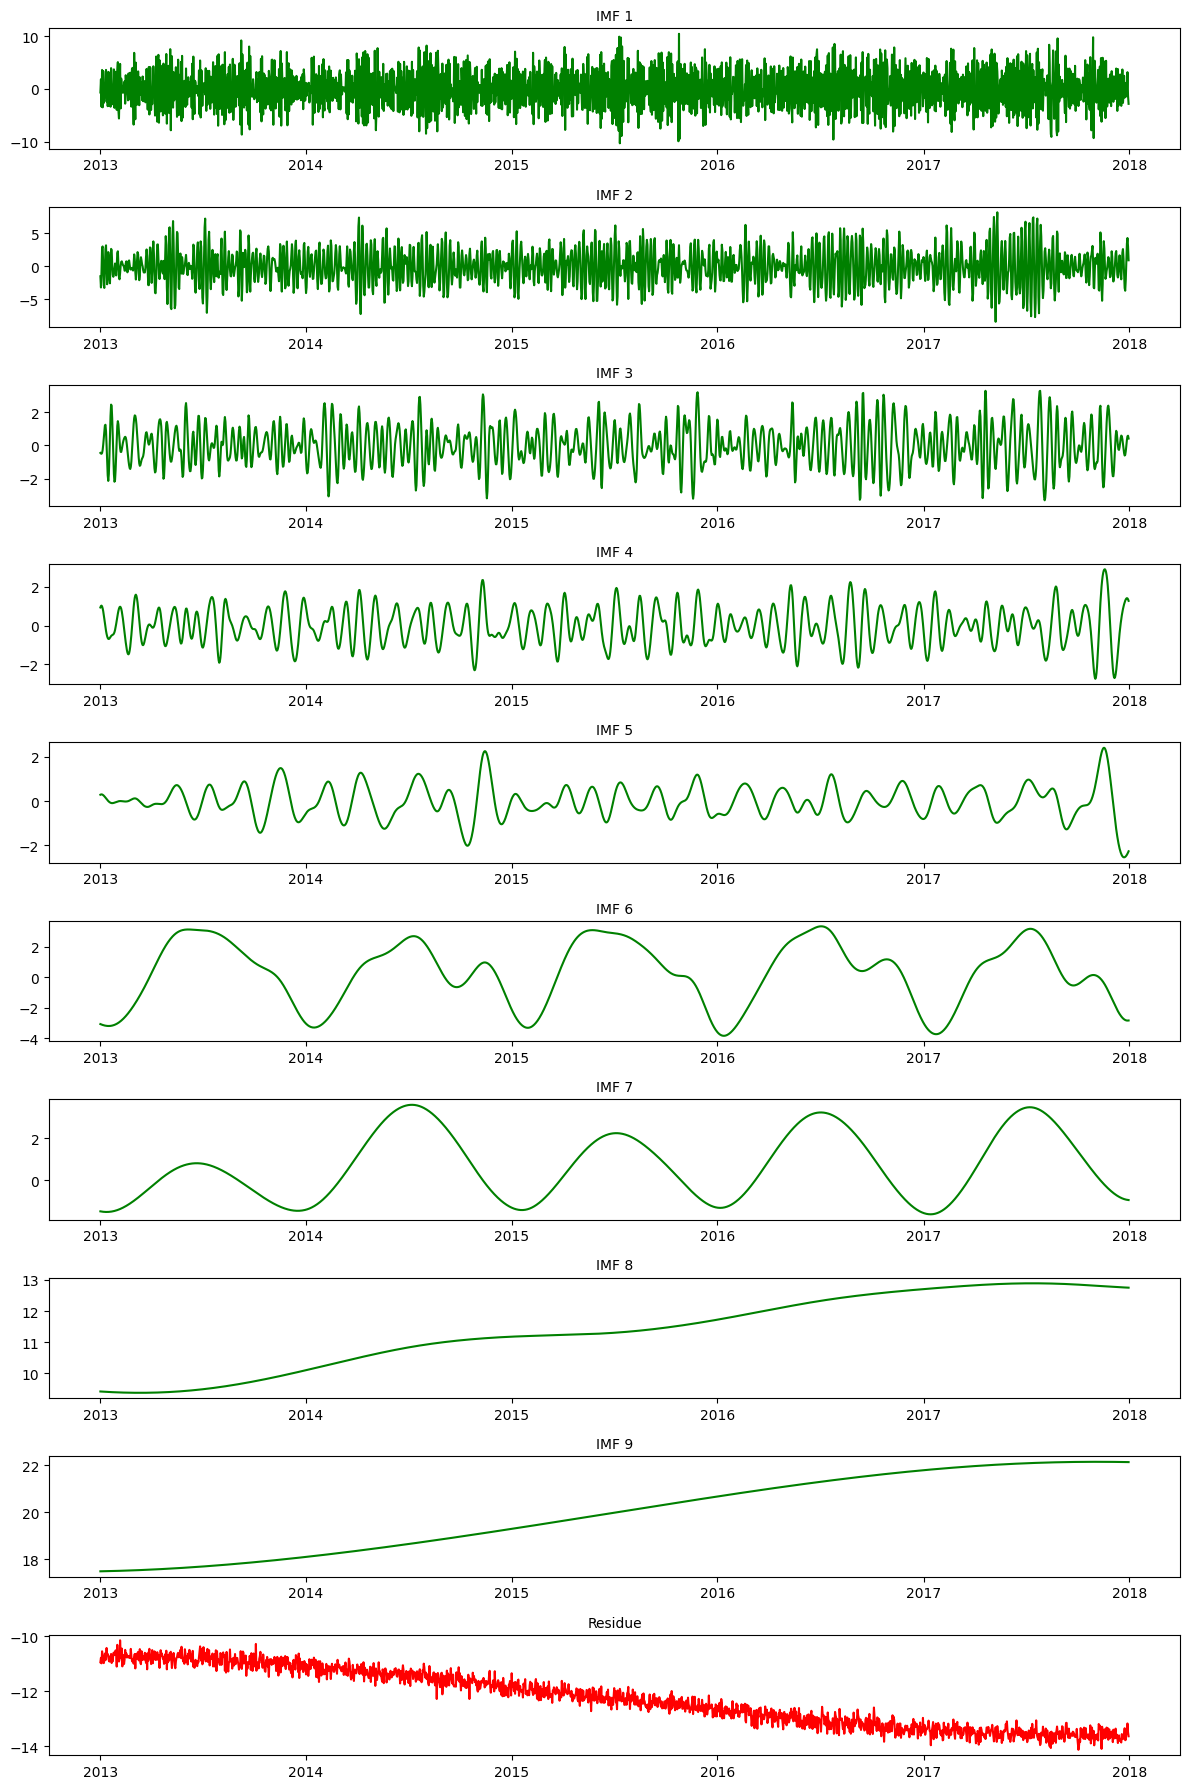

--------Total: 0~9 eIMFs, Now: eIMFs_0 --------
Search space summary
Default search space size: 8
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 480, 'step': 64, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
activation_3 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
dense_units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dense_activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'order

Exception ignored in: <function UniquePtr.__del__ at 0x000002414560C160>
Traceback (most recent call last):
  File "C:\Users\7info\anaconda3\envs\EEMD+LSTM\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 74, in __del__
    self.deleter(obj)
KeyboardInterrupt: 


Epoch 1/100
44/44 [==============================] - 18s 349ms/step - loss: 0.0510 - mape: 342276.7500 - mae: 0.1834 - val_loss: 0.0374 - val_mape: 46.4705 - val_mae: 0.1718
Epoch 2/100
44/44 [==============================] - 15s 337ms/step - loss: 0.0360 - mape: 387932.1250 - mae: 0.1598 - val_loss: 0.0387 - val_mape: 42.5173 - val_mae: 0.1714
Epoch 3/100
44/44 [==============================] - 15s 333ms/step - loss: 0.0347 - mape: 326534.2812 - mae: 0.1574 - val_loss: 0.0374 - val_mape: 46.1640 - val_mae: 0.1717
Epoch 4/100
44/44 [==============================] - 15s 330ms/step - loss: 0.0346 - mape: 352130.5938 - mae: 0.1574 - val_loss: 0.0374 - val_mape: 45.6595 - val_mae: 0.1715
Epoch 5/100
44/44 [==============================] - 15s 331ms/step - loss: 0.0344 - mape: 338827.1250 - mae: 0.1571 - val_loss: 0.0397 - val_mape: 41.6157 - val_mae: 0.1721
Epoch 6/100
44/44 [==============================] - 14s 328ms/step - loss: 0.0359 - mape: 323110.1562 - mae: 0.1596 - val_loss: 0

In [ ]:
for code in codes:
    print("==================================")
    print(f"========== { code } ==========")
    print("==================================")
    execute_EEMD_LSTM(code)